# 🚗 Car Price Prediction (Machine Learning)

## 📌 Project Overview
In this notebook, we build a **machine learning model** to predict the price of used cars based on real data stored in a **MySQL database**.

Instead of using a CSV file directly, we load data from SQL, preprocess it, train a model, and save it for later use in a **Python GUI application**.

---

## 🗂️ Data Source
The data is stored in a MySQL database and includes information such as:

- Car brand and model  
- Production year  
- Mileage  
- Gear type (Manual / Automatic)  
- Fuel type (Petrol / Diesel)  
- Car price (target variable)

📌 The data is fetched directly from the database using `mysql.connector` and `pandas`.

---

## 🔄 Workflow
This notebook follows these steps:

1️⃣ Connect to the MySQL database  
2️⃣ Load car data into a Pandas DataFrame  
3️⃣ Preprocess the data (encoding categorical features)  
4️⃣ Train a machine learning model  
5️⃣ Evaluate model performance  
6️⃣ Save the trained model for later predictions  

---

## ⚙️ Why SQL Instead of CSV?
Using a database allows us to:

- Store large amounts of data efficiently  
- Insert new car records dynamically  
- Train the model on **real-world structured data**  
- Re-train the model easily when new data is added  

This approach is closer to **production-ready machine learning systems**.

---

## 🥅 Goal
The final goal is to create a trained model that can predict car prices and be used inside a **Python GUI (PySide6)** application.

🚀 Let's get started!

In [14]:
# Imports
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split , KFold , cross_validate , GridSearchCV
from sklearn.linear_model import LogisticRegression , Lasso , Ridge , ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor , AdaBoostRegressor , GradientBoostingRegressor
from sklearn.metrics import r2_score , mean_absolute_error

In [2]:
# SQL Connection
conn = mysql.connector.connect(
    host = 'localhost',
    username = 'root',
    password = 'amir1234',
    database = 'car_price'
)

query = """
        SELECT
            brand,
            model,
            year,
            mileage,
            gear_type,
            full_type,
            price
        FROM cars
        """
data = pd.read_sql(query,conn)
print(data.head(5)) # Display the first 5 rows of the dataset

        brand  model  year  mileage gear_type  full_type         price
0       saipa    111  1399    89000    manual     petrol  6.300000e+08
1       saipa  quick  1400    59000    manual     petrol  7.000000e+08
2  brilliance   H320  1396    98000      auto     petrol  1.189000e+09
3       saipa    132  1392   220000    manual  dual_fuel  4.650000e+08
4     peugeot    206  1388   360000    manual     petrol  4.450000e+08


C:\Users\madrid\AppData\Local\Temp\ipykernel_5200\4288312684.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query,conn)


## ⚠️ Note about Database Connection

The data is loaded using a direct MySQL connection (`mysql.connector`) instead of SQLAlchemy.

🔹 This may trigger a pandas warning, but the data is loaded correctly.  
🔹 For simplicity and learning purposes, this approach is kept as-is.  
🔹 In production-level systems, **SQLAlchemy** is recommended.

✅ This warning does **not** affect model training or results.

---

---

## 🔧 Feature Engineering

Categorical features are converted into numerical values to make them usable for machine learning models:

- ⚙️ **Gear Type** is encoded as binary values (manual / automatic)
- ⛽ **Fuel Type** is encoded as binary values (petrol / dual fuel)
- 🚗 **Brand and Model** are merged into a single feature to reduce dimensionality

This step ensures the data is clean, compact, and model-ready.

In [3]:
# Encode gear type as binary values (manual = 0, automatic = 1)
data['gear_type'] = data['gear_type'].map({
    'manual' : 0,
    'auto' : 1
})

# Encode fuel type as binary values (petrol = 0, dual fuel = 1)
data['full_type'] = data['full_type'].map({
    'petrol' : 0,
    'dual_fuel' : 1
})

# Combine brand and model into a single categorical feature
# Drop original brand and model columns after merging
data['car_name'] = data['brand'] + '_' + data['model']
data = data.drop(columns=['brand','model'])

# ==================== Display =========================
pd.options.display.float_format = '{:,.0f}'.format
pd.set_option('display.width',1000)
print(data.head(5),'\n')                      # Display the first 5 rows of the dataset
print(data.shape,'\n')                        # Display the number of rows and columns in the dataset
print(data.dtypes,'\n')                       # Printing the data types of all columns to understand which features are numeric or categorical
print(data.describe(),'\n')                   # Show a statistical summary of all numerical columns (count, mean, std, min, max, etc.)
print(data.groupby('gear_type').size(),'\n')  # Grouping data by target to check distribution
print(data.groupby('full_type').size(),'\n')  # Grouping data by target to check distribution

   year  mileage  gear_type  full_type         price         car_name
0  1399    89000          0          0   630,000,000        saipa_111
1  1400    59000          0          0   700,000,000      saipa_quick
2  1396    98000          1          0 1,189,000,000  brilliance_H320
3  1392   220000          0          1   465,000,000        saipa_132
4  1388   360000          0          0   445,000,000      peugeot_206 

(108, 6) 

year           int64
mileage        int64
gear_type      int64
full_type      int64
price        float64
car_name      object
dtype: object 

       year   mileage  gear_type  full_type         price
count   108       108        108        108           108
mean  1,394   171,041          0          0   738,722,222
std       7   146,429          0          0   399,340,200
min   1,365         0          0          0    72,000,000
25%   1,388    69,000          0          0   491,250,000
50%   1,395   150,000          0          0   687,500,000
75%   1,400   235,0

## 📊 Data Visualization Overview

To better understand the dataset and detect patterns, the following visualizations are used:

- 📈 **Histogram**  
  Shows the distribution of numerical features and helps identify skewness and outliers.

- 🌊 **Density Plot**  
  Displays the probability density of values, providing a smoother view of data distribution.

- 📦 **Box Plot**  
  Highlights the median, quartiles, and potential outliers in the data.

- 🔥 **Heatmap**  
  Visualizes correlations between features and helps identify strong relationships with the target variable.

These plots provide essential insights before training the machine learning model.

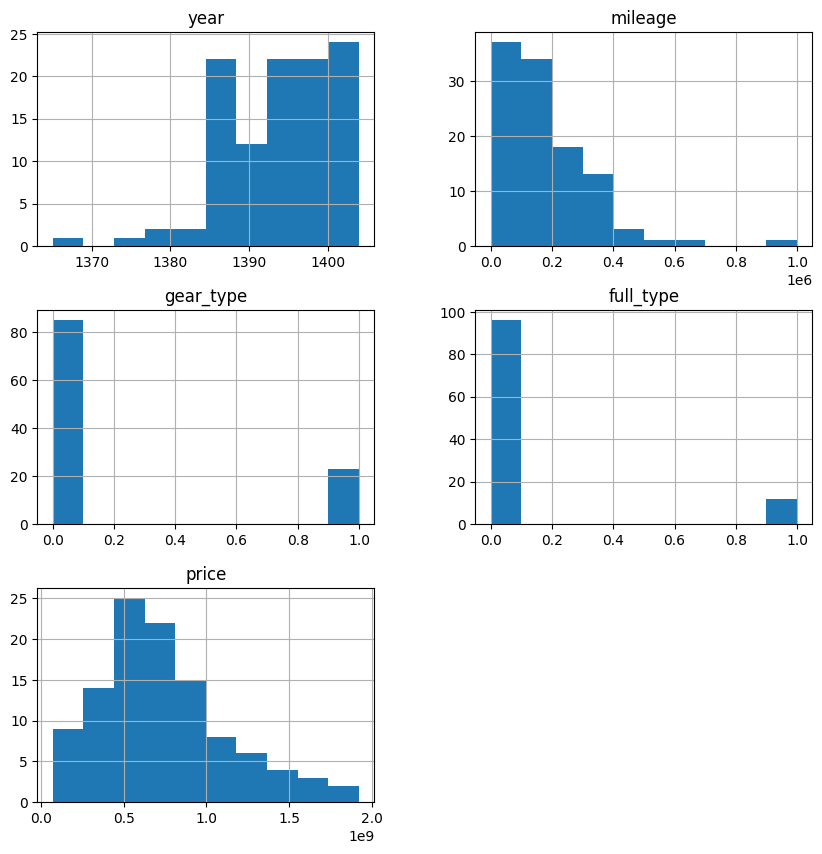

In [4]:
# Histogram
data.hist(figsize=(10,10))
plt.show()

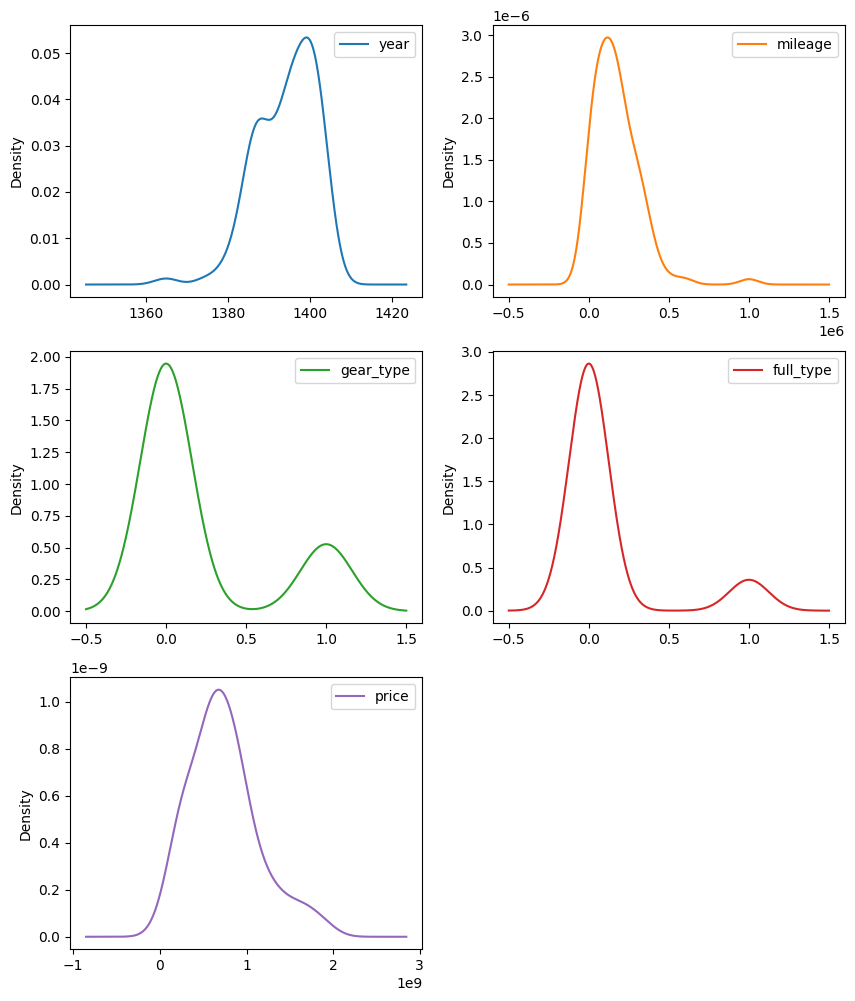

In [5]:
# Density
data.plot(kind='density',subplots=True,layout=(3,2),sharex=False,figsize=(10,12))
plt.show()

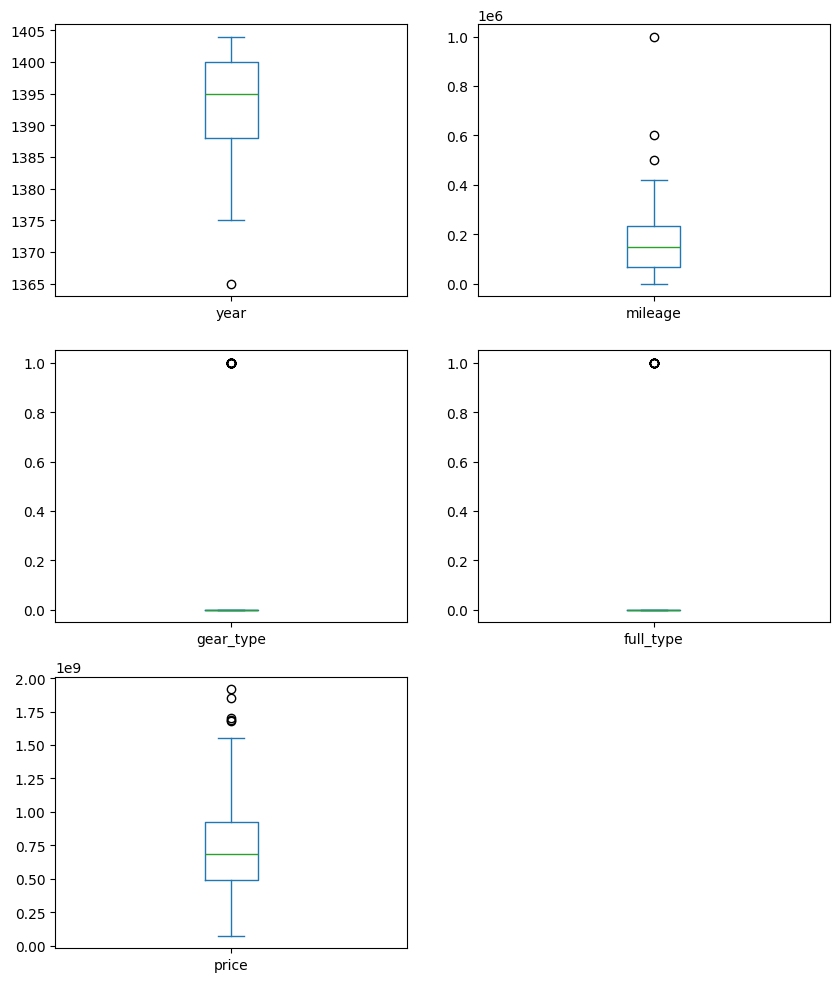

In [6]:
# Boxplot
data.plot(kind='box',subplots=True,layout=(3,2),sharex=False,figsize=(10,12))
plt.show()

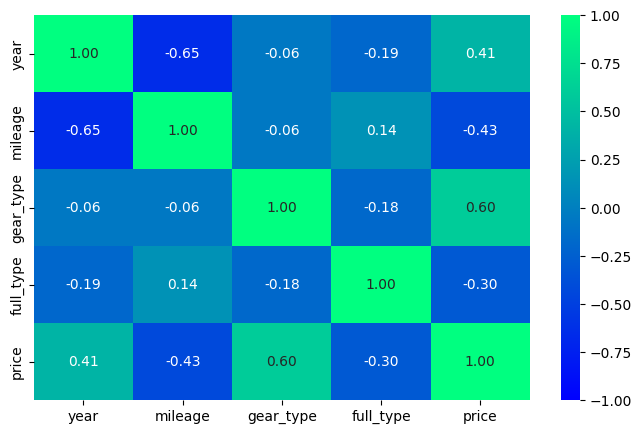

In [7]:
# Separate numeric and categorical columns
numeric_cols = data.drop(columns=['car_name',])

# Heatmap
plt.figure(figsize=(8,5))
sns.heatmap(numeric_cols.corr(),vmin=-1,vmax=1,cmap='winter',annot=True,fmt='.2f')
plt.show()

## 📝 Data Analysis Summary

Based on the visualizations and exploratory analysis, the following observations were made:

- 📊 **Distributions**  
  Most numerical features show approximately **Gaussian-like distributions**, although noticeable skewness is present.

- 🚨 **Outliers**  
  A significant number of **outliers** are observed, especially in the **price** feature.

- 🔗 **Correlation Analysis**  
  The correlation matrix reveals a mix of:
  - Strong positive correlations  
  - Negative correlations  
  - Weak or near-zero correlations  

These insights highlight the complexity of the data and justify the need for careful preprocessing and model selection.

---

---

## 🔢 One-Hot Encoding with `get_dummies`

`pd.get_dummies` converts **categorical/string features** into **numerical columns**:

- Each unique category becomes a separate column  
- Value = 1 if the row has that category, 0 otherwise  
- `prefix` adds a label to the column names for clarity

This makes string-based data usable for **machine learning models**. 🚀

In [8]:
car_name_dummies = pd.get_dummies(data['car_name'],prefix='car')
data = pd.concat([data,car_name_dummies],axis=1)
data = data.drop(columns=['car_name',])

## 🧪 Train/Test Split

Before training our machine learning model, we need to **split the dataset** into:

- **Training set**: Used to train the model
- **Test set**: Used to evaluate the model's performance on unseen data  

📌 This ensures that the model **generalizes well** and is not just memorizing the training data.

We typically use **scikit-learn's `train_test_split`** for a simple and reproducible split.

In [9]:
# =========== Base Setting ===========
random_state = 7
scoring = ['r2','neg_mean_absolute_error']
kfold = KFold(n_splits=10,shuffle=True,random_state=random_state)
# ====================================

X = data.drop(columns=['price',])
Y = data['price']
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.22,random_state=random_state)

## 🔎 Spot Check of Machine Learning Models with Standardization

Before choosing the final model, we perform a **quick evaluation** of several algorithms to see which one works best on our data:

- **Linear Regression (LR)** – basic linear model  
- **Lasso Regression (L1)** – adds L1 regularization to reduce overfitting  
- **Ridge Regression (L2)** – adds L2 regularization for stability  
- **ElasticNet (EN)** – combines L1 and L2 regularization  
- **K-Nearest Neighbors (KNN)** – predicts based on nearby points  
- **Decision Tree (CART)** – splits data into branches based on features  
- **Support Vector Machine (SVM)** – fits data using margin maximization  

### 🚀 How it works
- All models are trained using a **Pipeline that includes standardization** for numerical features  
- Performance is **compared using metrics** like MAE and R²  
- This ensures that models sensitive to feature scales (like Lasso, ElasticNet, SVM) **converge properly**  
- Allows us to **quickly spot the best candidates** before final tuning

In [10]:
# =========================================
# ⚠ ConvergenceWarning for LogisticRegression
# Due to the large number of one-hot encoded features and the range of numeric values, 
# the solver may take longer to converge. 
# We have applied StandardScaler, set solver='saga', and increased max_iter to 10000.
# The warning can be safely ignored for this project as the model predictions remain reliable.
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings('ignore',category=ConvergenceWarning)
# ===========================================
models = []
models.append(('LR',LogisticRegression(max_iter=10000,solver='saga',penalty='l2')))
models.append(('L1',Lasso(max_iter=5000)))
models.append(('L2',Ridge(max_iter=5000)))
models.append(('EN',ElasticNet(max_iter=5000)))
models.append(('KNN',KNeighborsRegressor()))
models.append(('CART',DecisionTreeRegressor()))
models.append(('SVM',SVR()))
for name , model in models:
    pipeline = Pipeline([
        ('Scaled',StandardScaler()),
        ('Classifier',model)
    ])
    cv_results = cross_validate(pipeline,x_train,y_train,cv=kfold,scoring=scoring)
    r2_mean = cv_results['test_r2'].mean() * 100
    mae_mean = -cv_results['test_neg_mean_absolute_error'].mean()
    print(f'Name : {name} , R2 Score : {r2_mean:.2f} , MAE Score : {mae_mean:.0f}')

Name : LR , R2 Score : 40.98 , MAE Score : 189866667
Name : L1 , R2 Score : 33.22 , MAE Score : 156623217
Name : L2 , R2 Score : 46.22 , MAE Score : 147495764
Name : EN , R2 Score : 51.92 , MAE Score : 160373325
Name : KNN , R2 Score : 30.36 , MAE Score : 199211944
Name : CART , R2 Score : 16.07 , MAE Score : 204913194
Name : SVM , R2 Score : -38.10 , MAE Score : 303591665


## 📋 Base Models Summary

After spot-checking several baseline models, we can summarize:

- **ElasticNet (EN)** – best linear model so far ✅  
- **Ridge (L2) & Linear Regression (LR)** – decent but slightly lower performance  
- **Lasso (L1)** – regularization reduces overfitting, slightly worse than EN  
- **KNN & CART** – non-linear, but MAE higher 🟡  
- **SVM** – poor performance on this dataset ❌

---

---

## 🌟 Ensemble Models

Ensemble methods combine multiple models to improve predictive performance and capture complex patterns in the data:

- **Random Forest (RF)** – robust, handles non-linear relationships, less sensitive to outliers 🌳  
- **Gradient Boosting (GBM)** – sequential learning to reduce errors, can achieve high accuracy ⚡  
- **AdaBoost (AB)** – focuses on correcting mistakes of weak learners 🎯  

### 🚀 Key Advantages
- Better handling of **non-linearities** and **interactions**  
- Often **higher R²** and **lower MAE** than single baseline models  
- Complements linear models like ElasticNet for a **hybrid system**

In [11]:
ensemble_models = []
ensemble_models.append(('RF',RandomForestRegressor(random_state=random_state)))
ensemble_models.append(('AB',AdaBoostRegressor()))
ensemble_models.append(('SGB',GradientBoostingRegressor()))
for name , model in ensemble_models:
    ensemble_pipeline = Pipeline([
        ('Scaled',StandardScaler()),
        ('Classifier',model)
    ])
    cv_results = cross_validate(ensemble_pipeline,x_train,y_train,cv=kfold,scoring=scoring)
    r2_mean = cv_results['test_r2'].mean() * 100
    mae_mean = -cv_results['test_neg_mean_absolute_error'].mean()
    print(f'Name : {name} , R2 Score : {r2_mean:.2f} , MAE Score : {mae_mean:.0f}')

Name : RF , R2 Score : 37.21 , MAE Score : 165549608
Name : AB , R2 Score : 26.73 , MAE Score : 190064233
Name : SGB , R2 Score : 39.71 , MAE Score : 164467806


## 🔧 Hyperparameter Tuning

After selecting the best-performing models, we proceed to **hyperparameter tuning** to further improve performance:

### 🧮 ElasticNet (EN)
- Tune regularization strength to balance bias and variance  
- Optimize the mix between **L1 and L2 penalties**  
- Helps stabilize the linear model and improve generalization  

### 🌳 Gradient Boosting (SGB)
- Adjust the number of trees to control model complexity  
- Tune learning rate to balance speed and accuracy  
- Optimize tree depth to capture non-linear patterns without overfitting  

### 🚀 Goal
- Reduce **MAE**  
- Increase **R² Score**  
- Select the **final production-ready model**

In [12]:
# We intentionally run GridSearch twice with different scoring metrics.
# MAE is used to evaluate the model based on real-world error magnitude (price difference),
# while R² is used to measure how well the model explains variance in the target variable.
# Since GridSearchCV can refit the model using only one metric at a time,
# we perform separate runs to fairly analyze model performance from both perspectives.

# R2 Scoring
model_grid = [
    ('EN',ElasticNet()),
    ('SGB',GradientBoostingRegressor())
]
param_grid = {
    'EN' : {
        'Classifier__alpha' : [0.01,0.1,1.0],
        'Classifier__l1_ratio' : [0.3,0.5,0.7,0.9],
        'Classifier__max_iter' : [1000,3000,5000]
    },

    'SGB' : {
        'Classifier__n_estimators' : [100,300,500],
        'Classifier__learning_rate' : [0.01,0.1,1.0],
        'Classifier__max_depth' : [3,5,7,9],
        'Classifier__subsample' : [0.5,0.7,1.0],
        'Classifier__min_samples_split' : [3,5,7],
        'Classifier__min_samples_leaf' : [1,2,4]
    }
}
for name , model in model_grid:
    pipeline_grid = Pipeline([
        ('Scaled',StandardScaler()),
        ('Classifier',model)
    ])
    grid = GridSearchCV(estimator=pipeline_grid,param_grid=param_grid[name],scoring='r2',n_jobs=-1,cv=kfold)
    grid.fit(x_train,y_train)
    print(f'{name} - Best CV R2 Score : {grid.best_score_*100:.2f}')
    print(f'{name} - Best params : {grid.best_params_}','\n')

EN - Best CV R2 Score : 53.61
EN - Best params : {'Classifier__alpha': 1.0, 'Classifier__l1_ratio': 0.7, 'Classifier__max_iter': 1000} 

SGB - Best CV R2 Score : 52.48
SGB - Best params : {'Classifier__learning_rate': 0.1, 'Classifier__max_depth': 7, 'Classifier__min_samples_leaf': 1, 'Classifier__min_samples_split': 3, 'Classifier__n_estimators': 100, 'Classifier__subsample': 0.5} 



In [13]:
# MAE Scoring
model_grid = [
    ('EN',ElasticNet()),
    ('SGB',GradientBoostingRegressor())
]
param_grid = {
    'EN' : {
        'Classifier__alpha' : [0.01,0.1,1.0],
        'Classifier__l1_ratio' : [0.3,0.5,0.7,0.9],
        'Classifier__max_iter' : [1000,3000,5000]
    },

    'SGB' : {
        'Classifier__n_estimators' : [100,300,500],
        'Classifier__learning_rate' : [0.01,0.1,1.0],
        'Classifier__max_depth' : [3,5,7,9],
        'Classifier__subsample' : [0.5,0.7,1.0],
        'Classifier__min_samples_split' : [3,5,7],
        'Classifier__min_samples_leaf' : [1,2,4]
    }
}
for name , model in model_grid:
    pipeline_grid = Pipeline([
        ('Scaled',StandardScaler()),
        ('Classifier',model)
    ])
    grid = GridSearchCV(estimator=pipeline_grid,param_grid=param_grid[name],scoring='neg_mean_absolute_error',n_jobs=-1,cv=kfold)
    grid.fit(x_train,y_train)
    print(f'{name} - Best CV MAE Score : {grid.best_score_:.2f}')
    print(f'{name} - Best params : {grid.best_params_}','\n')

EN - Best CV MAE Score : -147512056.19
EN - Best params : {'Classifier__alpha': 0.1, 'Classifier__l1_ratio': 0.9, 'Classifier__max_iter': 1000} 

SGB - Best CV MAE Score : -155002357.45
SGB - Best params : {'Classifier__learning_rate': 0.1, 'Classifier__max_depth': 3, 'Classifier__min_samples_leaf': 1, 'Classifier__min_samples_split': 7, 'Classifier__n_estimators': 300, 'Classifier__subsample': 0.5} 



## 🎯 Final Model for Prediction

After thorough evaluation and hyperparameter tuning, we have selected the **ElasticNet (EN)** model as our **final prediction model** ✅

### 🔹 Why ElasticNet?
- **Lower MAE** → more accurate price predictions 💰  
- **Higher R²** → better explanation of variance 📊  
- **Simple and interpretable** → easy integration into GUI 🖥️  
- **Stable and robust** → less risk of overfitting

### 🚀 Next Steps
- Use this model to **predict car prices** based on user-selected features  
- Integrate into **PySide6 GUI** for interactive predictions  
- Optionally, continue monitoring **performance on new data**

In [20]:
en_pipe = Pipeline([
    ('Scaled',StandardScaler()),
    ('Classifier',ElasticNet())
])
en_grid = GridSearchCV(
    estimator=en_pipe,
    param_grid=param_grid['EN'],
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=kfold
)
en_grid.fit(x_train,y_train)
prediction = en_grid.best_estimator_.predict(x_test)
r2 = r2_score(y_test,prediction)
mae = mean_absolute_error(y_test,prediction)
print(f'R2 Score : {r2*100:.2f}')
print(f'MAE Score : {mae:.2f}')

R2 Score : 32.38
MAE Score : 181956624.21


## 📋 Final Price Prediction Summury

- We use the **ElasticNet model** as our final predictor ✅  
- Model predicts car prices based on the selected features 🚗💰  
- **Current limitations:**  
  - Predictions can have high errors due to data variability ⚠️  
  - Outliers and skewed distributions affect accuracy 📊  
  - More advanced error handling or confidence intervals needed for user-friendly results 🛠️  
- Next steps will focus on **refining predictions and preparing for GUI integration** 🖥️

---

---

## 🎯 Price Prediction with Error Range

- Use the **ElasticNet model** for final car price predictions 🚗💰  
- Display **Predicted Price ± Approx. Error** ⚠️  
- Helps users understand **possible price range** without confusion 📊  

In [23]:
prediction_lower = prediction - mae
prediction_upper = prediction + mae
# Display
for pred , low , up in zip(prediction , prediction_lower , prediction_upper):
    print(f'Pridicted : {pred:,.0f} ± {mae:,.0f} -> Range : {low:,.0f} , {up:,.0f}','\n')

Pridicted : 403,924,514 ± 181,956,624 -> Range : 221,967,890 , 585,881,138 

Pridicted : 1,012,472,906 ± 181,956,624 -> Range : 830,516,282 , 1,194,429,530 

Pridicted : 682,893,201 ± 181,956,624 -> Range : 500,936,577 , 864,849,825 

Pridicted : 877,479,613 ± 181,956,624 -> Range : 695,522,988 , 1,059,436,237 

Pridicted : 295,791,429 ± 181,956,624 -> Range : 113,834,804 , 477,748,053 

Pridicted : 896,137,913 ± 181,956,624 -> Range : 714,181,289 , 1,078,094,537 

Pridicted : 640,282,743 ± 181,956,624 -> Range : 458,326,119 , 822,239,367 

Pridicted : 1,499,922,028 ± 181,956,624 -> Range : 1,317,965,404 , 1,681,878,652 

Pridicted : 406,302,786 ± 181,956,624 -> Range : 224,346,162 , 588,259,410 

Pridicted : 629,082,098 ± 181,956,624 -> Range : 447,125,474 , 811,038,722 

Pridicted : 630,983,089 ± 181,956,624 -> Range : 449,026,464 , 812,939,713 

Pridicted : 1,126,075,377 ± 181,956,624 -> Range : 944,118,752 , 1,308,032,001 

Pridicted : 1,055,627,211 ± 181,956,624 -> Range : 873,670

## 💾 Save Final Model & Pipeline

- After completing **data preprocessing, feature engineering, hyperparameter tuning, and final predictions** 🚀  
- **Save the trained ElasticNet model and Pipeline** to disk for future use
  - Ensures you can **load the model instantly** without retraining 
  - Makes the project **ready for GUI integration, deployment, or further analysis** 🖥️  
- **Benefits of saving the model:**  
  - ✅ Reproducibility: Use the same model anytime without repeating experiments  
  - ✅ Efficiency: Save time and computational resources  
  - ✅ Stability: Keep the final tuned model safe for production use  
- 🎉 This marks the **official completion of the main machine learning workflow**  

In [24]:
import joblib

final_model = en_grid.best_estimator_

# Saving
joblib.dump(final_model,'final_model.pkl')

print('✔ Success')

✔ Success
